In [73]:
import pandas as pd
import numpy as np
import pickle
from pandas import Timestamp
from collections import Counter

from sklearn.metrics import roc_curve, auc
import sys
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from pylab import rcParams
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

warnings.filterwarnings('ignore')

## Load data and clean

In [2]:
sessions = pickle.load(open('../Data/sessions.pkl', 'rb'))
events = pd.read_csv('../Data/events.csv')

In [3]:
sessions.head()

,session_id,start_timestamp,timezone,timezone_offset,previous_sessions_duration,user_created_timestamp,is_user_first_session,is_session,country,region,city,latitude,longitude,locale,os_name,session_index,device_id,user_id_hash
0,5558845121177764917,1542215364580,Asia/Manila,28800000,25837591,1538874289458,False,True,PH,00,makati,14.554729,121.024445,en_GB,Android OS,30,546a3d98-d540-4e72-ad82-9ebd64e0839b,9943447915df3a45fd6720a026af905b6da6b56a37701b...
1,2201961907282901522,1543712977293,Asia/Manila,28800000,35050130,1538874289458,False,True,PH,00,quezon city,14.676041,121.043701,en_GB,Android OS,47,546a3d98-d540-4e72-ad82-9ebd64e0839b,9943447915df3a45fd6720a026af905b6da6b56a37701b...
2,18781111175537580,1539215568666,Asia/Manila,28800000,11343848,1538874289458,False,True,PH,00,makati,14.554729,121.024445,en_GB,Android OS,10,546a3d98-d540-4e72-ad82-9ebd64e0839b,9943447915df3a45fd6720a026af905b6da6b56a37701b...
3,1477540082628742048,1540120743010,Asia/Manila,28800000,13499724,1538874289458,False,True,PH,11,davao city,7.190708,125.455338,en_GB,Android OS,13,546a3d98-d540-4e72-ad82-9ebd64e0839b,9943447915df3a45fd6720a026af905b6da6b56a37701b...
4,8184875317380844086,1542671625528,Asia/Manila,28800000,32788010,1538874289458,False,True,PH,00,makati,14.554729,121.024445,en_GB,Android OS,41,546a3d98-d540-4e72-ad82-9ebd64e0839b,9943447915df3a45fd6720a026af905b6da6b56a37701b...


In [4]:
Counter(sessions.is_session)

Counter({True: 5157590, False: 1041746})

In [5]:
events.head()

,app_id,session_id,event,event_timestamp,event_value,user_id_hash
0,4724682771660800,5558845121177764917,45,1542215397132,0.0,9943447915df3a45fd6720a026af905b6da6b56a37701b...
1,4724682771660800,5558845121177764917,45,1542215484895,0.0,9943447915df3a45fd6720a026af905b6da6b56a37701b...
2,4724682771660800,7689508378645584666,.m5100869650219008,1541124410372,0.0,9943447915df3a45fd6720a026af905b6da6b56a37701b...
3,4724682771660800,2201961907282901522,4,1543713091129,0.0,9943447915df3a45fd6720a026af905b6da6b56a37701b...
4,4724682771660800,2201961907282901522,6,1543713093116,0.0,9943447915df3a45fd6720a026af905b6da6b56a37701b...


In [6]:
sessions = sessions.drop(['timezone_offset', 'timezone', 'is_user_first_session', 'city', 'region',
                        'latitude', 'longitude', 'locale', 'device_id'], axis=1).dropna()
sessions = sessions[sessions['is_session']==True].drop('is_session', axis=1)
sessions['start_timestamp'] = pd.to_datetime(sessions['start_timestamp'], unit='ms')
sessions['user_created_timestamp'] = pd.to_datetime(sessions['user_created_timestamp'], unit='ms')
sessions = sessions.sort_values(by='start_timestamp')
sessions = sessions.reset_index(drop=True)

In [7]:
events = events.drop('app_id', axis=1)
events = events[events['event'].map(lambda x: x[0]!='.')]
events['event_timestamp'] = pd.to_datetime(events['event_timestamp'],unit='ms')
events = events.sort_values(by='event_timestamp')
events = events.reset_index(drop=True)

In [8]:
sessions.head()

,session_id,start_timestamp,previous_sessions_duration,user_created_timestamp,country,os_name,session_index,user_id_hash
0,4339488202460077611,2018-10-01 07:00:04.526,0,2018-10-01 07:00:04.526,AU,iPhone OS,1,c9bad12f865142f1b3938c9ab8a3003a7882136a2b4a12...
1,7012480646309837595,2018-10-01 07:00:08.476,0,2018-10-01 07:00:08.476,NZ,iOS,1,285863e47df26bf47664c93d45c35ee3b9cfc8e253da23...
2,2920311224184894615,2018-10-01 07:01:02.101,1000637,2018-10-01 06:44:08.468,IN,Android OS,2,475f8f20576637055c5331513dda4db1d889f5e951c8e5...
3,8483277250870486701,2018-10-01 07:01:30.694,0,2018-10-01 07:01:30.694,US,Android OS,1,4bc7b52d56b24d258ba1746994492f354fd4b17fcaae81...
4,8114762104527844914,2018-10-01 07:01:57.770,2415582,2018-10-01 06:18:23.919,US,Android OS,2,82349b0d1a80b42e59519068ded46178778084b9602b9c...


In [9]:
events.head()

,session_id,event,event_timestamp,event_value,user_id_hash
0,7012480646309837595,44,2018-10-01 07:00:40.514,0.0,285863e47df26bf47664c93d45c35ee3b9cfc8e253da23...
1,7012480646309837595,5,2018-10-01 07:00:42.744,0.0,285863e47df26bf47664c93d45c35ee3b9cfc8e253da23...
2,7012480646309837595,45,2018-10-01 07:01:06.395,0.0,285863e47df26bf47664c93d45c35ee3b9cfc8e253da23...
3,7012480646309837595,14,2018-10-01 07:01:44.065,0.0,285863e47df26bf47664c93d45c35ee3b9cfc8e253da23...
4,4339488202460077611,44,2018-10-01 07:01:54.780,0.0,c9bad12f865142f1b3938c9ab8a3003a7882136a2b4a12...


In [10]:
print(len(sessions), len(events))

5157590 109627861


## Get train/val data & label, test data

In [14]:
# events_train
events_train_data = events[events['event_timestamp'] <= (events.event_timestamp[0] + pd.Timedelta(days=42))]
events_train_label = events[np.logical_and(events['event_timestamp'] > (events.event_timestamp[0] + pd.Timedelta(days=42)),
                            events['event_timestamp'] <= (events.event_timestamp[0] + pd.Timedelta(days=56)))]

# events_val
events_val_data = events[np.logical_and(events['event_timestamp'] <= (events.event_timestamp.iloc[-1] - pd.Timedelta(days=14)),
                        events['event_timestamp'] > (events.event_timestamp.iloc[-1] - pd.Timedelta(days=56)))]
events_val_label = events[events['event_timestamp'] > (events.event_timestamp.iloc[-1] - pd.Timedelta(days=14))]

# events_predict
events_predict_data = events[events['event_timestamp'] > (events.event_timestamp.iloc[-1] - pd.Timedelta(days=42))]

In [26]:
# sessions_train
sessions_train_data = sessions[sessions['start_timestamp'] <= (sessions.start_timestamp[0] + pd.Timedelta(days=42))]

# sessions_val
sessions_val_data = sessions[np.logical_and(sessions['start_timestamp'] <= (sessions.start_timestamp.iloc[-1] - pd.Timedelta(days=14)),
                        sessions['start_timestamp'] > (sessions.start_timestamp.iloc[-1] - pd.Timedelta(days=56)))]

# sessions_predict
sessions_predict_data = sessions[sessions['start_timestamp'] > (sessions.start_timestamp.iloc[-1] - pd.Timedelta(days=42))]

### train and val labels

In [39]:
# train label (0, 1)
events_train_7_days = events_train_label[events_train_label['event_timestamp']
                                         <= (events_train_label.event_timestamp.iloc[-1] - pd.Timedelta(days=7))].\
                        groupby('user_id_hash')['event'].apply(lambda x: list(x)).reset_index()
events_train_14_days = events_train_label.groupby('user_id_hash')['event'].apply(lambda x: list(x)).reset_index()
events_train_7_days['user_purchase_binary_7_days'] = [int('8' in e) for e in events_train_7_days.event]
events_train_14_days['user_purchase_binary_14_days'] = [int('8' in e) for e in events_train_14_days.event]
train_label = events_train_14_days.merge(events_train_7_days, how='left', on='user_id_hash').fillna(0)
train_label = train_label.drop(['event_x', 'event_y'], axis=1)

In [40]:
train_label.head()

,user_id_hash,user_purchase_binary_14_days,user_purchase_binary_7_days
0,00000db35682058bb7916cb90f85709f54c1a0f7a3b6de...,1,1.0
1,000059859ec188af6035870faf885c3038cedda05b3a54...,1,0.0
2,000081a7d841b0f953bdba6c185fd5cc335fd6015a30c3...,0,0.0
3,0000a464ad921c3288e73a3a788b5f113cabf84251a74b...,0,0.0
4,0000e2a3c14887640e2ccf2902b23e6b627856fab9efd6...,0,0.0


In [42]:
len(train_label)

214460

In [43]:
# val label (0, 1)
events_val_7_days = events_val_label[events_val_label['event_timestamp']
                                         <= (events_val_label.event_timestamp.iloc[-1] - pd.Timedelta(days=7))].\
                        groupby('user_id_hash')['event'].apply(lambda x: list(x)).reset_index()
events_val_14_days = events_val_label.groupby('user_id_hash')['event'].apply(lambda x: list(x)).reset_index()
events_val_7_days['user_purchase_binary_7_days'] = [int('8' in e) for e in events_val_7_days.event]
events_val_14_days['user_purchase_binary_14_days'] = [int('8' in e) for e in events_val_14_days.event]
val_label = events_val_14_days.merge(events_val_7_days, how='left', on='user_id_hash').fillna(0)
val_label = val_label.drop(['event_x', 'event_y'], axis=1)

In [44]:
val_label.head()

,user_id_hash,user_purchase_binary_14_days,user_purchase_binary_7_days
0,00000db35682058bb7916cb90f85709f54c1a0f7a3b6de...,0,0.0
1,000081a7d841b0f953bdba6c185fd5cc335fd6015a30c3...,0,0.0
2,0000a464ad921c3288e73a3a788b5f113cabf84251a74b...,0,0.0
3,0000bc4e8bfc829d327fa69bdc426dd8a789c52550ed87...,0,0.0
4,00020102f66f89759868c843ae9fe634870f132f9e3d79...,0,0.0


In [45]:
len(val_label)

84467

### train and val data

In [46]:
def get_data(df_data, df_label):
    return df_data[df_data['user_id_hash'].isin(df_label.user_id_hash)]

In [47]:
event_train_data = get_data(events_train_data, train_label)
session_train_data = get_data(sessions_train_data, train_label)

event_val_data = get_data(events_val_data, val_label)
session_val_data = get_data(sessions_val_data, val_label)

In [48]:
print(len(event_train_data), len(session_train_data), len(event_val_data), len(session_val_data))

29584175 1355719 36160675 1691534


In [49]:
event_train_data = event_train_data.reset_index(drop=True)
session_train_data = session_train_data.reset_index(drop=True)

event_val_data = event_val_data.reset_index(drop=True)
session_val_data = session_val_data.reset_index(drop=True)

In [ ]:
# attributes
attr1 = pd.read_csv('../Data/attr1.csv')
attr_train_data = get_data(attr1, train_label)
attr_val_data = get_data(attr1, val_label)

### predict data

In [52]:
submission = pd.read_csv('../Data/sample_submission_2.csv')
submission = submission.drop(['user_purchase_binary_7_days', 'user_purchase_binary_14_days'], axis=1)

event_predict_data = get_data(events_predict_data, submission)
session_predict_data = get_data(sessions_predict_data, submission)

attr_predict_data = get_data(attr1, submission)

### in case of no validation

In [131]:
events_data = events[events['event_timestamp']<=(events.event_timestamp.iloc[-1] - pd.Timedelta(days=14))]
events_label = events[events['event_timestamp']>(events.event_timestamp.iloc[-1] - pd.Timedelta(days=14))]
sessions_data = sessions[sessions['start_timestamp']<=(sessions.start_timestamp.iloc[-1]-pd.Timedelta(days=14))]

In [132]:
events_7_days = events_label[events_label['event_timestamp']
                             <=(events.event_timestamp[events.shape[0]-1] - pd.Timedelta(days=7))].\
                groupby('user_id_hash')['event'].apply(lambda x: list(x)).reset_index()
events_14_days = events_label.groupby('user_id_hash')['event'].apply(lambda x: list(x)).reset_index()
events_7_days['user_purchase_binary_7_days'] = [int('8' in e) for e in events_7_days.event]
events_14_days['user_purchase_binary_14_days'] = [int('8' in e) for e in events_14_days.event]
training_label = events_14_days.merge(events_7_days, how='left', on='user_id_hash').fillna(0)
training_label = training_label.drop(['event_x', 'event_y'], axis=1)

In [133]:
event_data = get_data(events_data, training_label)
session_data = get_data(sessions_data, training_label)
event_data = event_data.reset_index(drop=True)
session_data = session_data.reset_index(drop=True)

In [ ]:
event = get_data(events, submission)
session = get_data(sessions, submission)

## Feature Engineering

In [56]:
def avg_diff(ls, seven_endtime, last=0):
    '''calculate average intervals'''
    if last:
        ls2 = [e for e in ls if e > seven_endtime]
        if len(ls2) == 0: return 168  # no event last week
        if len(ls2) == 1: return 84  # only one event last week
        return avg_diff(ls2, seven_endtime)
    else:
        if len(ls) == 1: return 504
        if len(ls) == 0: return 1008
        return sum([(ls[i+1] - ls[i]).total_seconds()/3600 for i in range(len(ls)-1)])/(len(ls)-1)   

In [57]:
def standardize(ls):
    mean = ls.mean()
    std = ls.std()
    ls = (ls - mean)/std
    return ls

### feature from events

In [58]:
def compute_event_features(events):
    '''compute featuers from events'''
    
    
    user_id_hash = events.groupby('session_id')["user_id_hash"].first().reset_index(name="user_id_hash")
    # number of events in each session
    num_events = events.groupby('session_id')["event"].count().reset_index(name="event_count")
    # duration = last event - first event
    first_event = events.groupby('session_id')['event_timestamp'].first().reset_index(name="first_event")
    last_event = events.groupby('session_id')['event_timestamp'].last().reset_index(name="last_event")
    duration = first_event.join(last_event.set_index('session_id'), on='session_id')
    duration['duration'] = duration['last_event'] - duration['first_event']
    duration['duration'] = [e.total_seconds()/3600 for e in duration.duration]  # in hours
    
    
    event_endtime = events.event_timestamp.iloc[-1]
    seven_endtime = pd.to_datetime(event_endtime) - pd.Timedelta(days=7)
    per_session = user_id_hash.merge(num_events,on='session_id').merge(duration,on='session_id')

    # time spent on the app in hours
    total_time = per_session.groupby('user_id_hash')['duration'].sum().reset_index(name='total_time')
    total_time_last_week = per_session[per_session['first_event']>seven_endtime].\
                            groupby('user_id_hash')['duration'].sum().reset_index(name='total_time_last_week')

    # avg session duration
    avg_session_duration = per_session.groupby('user_id_hash')['duration'].mean().reset_index(name='avg_session_duration')
    avg_session_duration_last_week = per_session[per_session['first_event']>seven_endtime].\
                                        groupby('user_id_hash')['duration'].mean().\
                                        reset_index(name='avg_session_duration_last_week')

    # avg count of events in each session
    avg_event_count = per_session.groupby('user_id_hash')['event_count'].mean().reset_index(name='avg_event_count')

    # sum of purchase
    sum_purchase_value = events[events['event']=='8'].groupby('user_id_hash')['event_value'].\
                            sum().reset_index(name='sum_purchase_value')
    sum_purchase_value_last_week = events[(events['event']=='8') & (events['event_timestamp']>seven_endtime)].\
                            groupby('user_id_hash')['event_value'].\
                            sum().reset_index(name='sum_purchase_value_last_week')

    # number of purchase
    purchase_count = events[events['event']=='8'].groupby('user_id_hash')['event_value'].\
                            count().reset_index(name='purchase_count')
    purchase_count_last_week = events[(events['event']=='8') & (events['event_timestamp']>seven_endtime)].\
                            groupby('user_id_hash')['event_value'].\
                            count().reset_index(name='purchase_count_last_week')
    
    
    event_features = total_time.merge(total_time_last_week, how='left', on='user_id_hash').\
                    merge(avg_session_duration, on='user_id_hash').\
                    merge(avg_session_duration_last_week, how='left', on='user_id_hash').\
                    merge(avg_event_count, on='user_id_hash').\
                    merge(sum_purchase_value, how='left', on='user_id_hash').\
                    merge(sum_purchase_value_last_week, how='left', on='user_id_hash').\
                    merge(purchase_count, how='left', on='user_id_hash').\
                    merge(purchase_count_last_week, how='left', on='user_id_hash').fillna(0)
    
    
    # avg interval between purchases in hours
    purchase_events = events[events['event']=='8'][['event_timestamp', 'user_id_hash']].groupby('user_id_hash').\
                        agg({'event_timestamp': lambda x: list(x)})
    
    
    purchase_events['purchase_interval'] = purchase_events.event_timestamp.\
                                            apply(lambda x: avg_diff(x, seven_endtime))
    purchase_events['purchase_interval_last_week'] = purchase_events.event_timestamp.\
                                                    apply(lambda x: avg_diff(x, seven_endtime, 1))
    purchase_events = purchase_events.drop('event_timestamp', axis=1)
    event_features = event_features.merge(purchase_events, how='left', on='user_id_hash')
    event_features['purchase_interval'] = event_features['purchase_interval'].fillna(1008)
    event_features['purchase_interval_last_week'] = event_features['purchase_interval_last_week'].fillna(168)
    
    
    return event_features

### features from sessions

In [63]:
def compute_session_features(sessions):
    '''compute features from sessions'''
    
    
    session_endtime = sessions.start_timestamp.iloc[-1]
    seven_endtime = pd.to_datetime(session_endtime) - pd.Timedelta(days=7)
    
    
    session_timestamp = sessions.groupby('user_id_hash').agg({'start_timestamp': lambda x: list(x)})
    user_sessions = sessions.groupby('user_id_hash').agg({'session_id': 'count',
                                                          'previous_sessions_duration': 'mean',
                                                          'user_created_timestamp': lambda x: x.iloc[0],
                                                          'country': lambda x: x.iloc[0],
                                                          'os_name': lambda x: x.iloc[0]}).\
                                                     merge(session_timestamp, on='user_id_hash')
    user_sessions = user_sessions.rename(columns={'session_id':'session_count', 
                                                  'previous_sessions_duration':'avg_session_duration'})
    user_sessions['avg_session_duration'] = [e/3600000 for e in user_sessions.avg_session_duration]
    
    
    user_sessions['elapse_since_last_session'] = [(session_endtime-e[-1]).total_seconds()/3600 for e in user_sessions.start_timestamp]
    user_sessions['since_register'] = [(session_endtime-e).total_seconds()/3600 for e in user_sessions.user_created_timestamp]
    
    
    user_sessions['avg_session_interval'] = user_sessions.start_timestamp.\
                                        apply(lambda x: avg_diff(x, seven_endtime))
    user_sessions['avg_session_interval_last_week'] = user_sessions.start_timestamp.\
                                                    apply(lambda x: avg_diff(x, seven_endtime, 1))
    user_sessions = user_sessions.drop(['user_created_timestamp', 'start_timestamp'], axis=1).reset_index()
    
    
    return user_sessions

### features from attributes

### combine features

In [70]:
def compute_features(event_data, session_data):
    '''
    combine features from sessions and events
    '''
    
    # event_X
    event_X = compute_event_features(event_data)
    for c in list(event_X.columns)[1:]:
        event_X[c] = standardize(event_X[c])
    
    # session_X
    session_X = compute_session_features(session_data)
    for c in ['session_count', 'avg_session_duration','elapse_since_last_session', 'since_register',
           'avg_session_interval', 'avg_session_interval_last_week']:
        session_X[c] = standardize(session_X[c])
    session_X = session_X.drop(['country', 'os_name'], axis=1)
    
    # combine to X
    X = event_X.merge(session_X, how='inner', on='user_id_hash').reset_index(drop=True)
    
    
    return X

## Model

### X_train, y_train, X_val, y_val, X_predict

In [71]:
# train

X_train = compute_features(event_train_data, session_train_data)
y_train = train_label[train_label['user_id_hash'].isin(X_train.user_id_hash)]
len(X_train)

78177

In [76]:
# val

X_val = compute_features(event_val_data, session_val_data)
y_val = val_label[val_label['user_id_hash'].isin(X_val.user_id_hash)]
len(X_val)

79492

In [77]:
# test

X_predict = compute_features(event_predict_data, session_predict_data)
len(X_predict)

163737

### Random Forest

In [84]:
############################## 7 days ##############################

rf = RandomForestClassifier()

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': list(range(5, 10)),
    'max_leaf_nodes': list(range(8, 12)),
    'min_samples_split': [2,4,8],
    'max_features': ['sqrt', 'auto', 'log2']
}

rf_gs = GridSearchCV(estimator=rf, param_grid=param_grid)
rf_gs.fit(X_train.iloc[:,1:], y_train['user_purchase_binary_7_days'])

rf_7 = rf_gs.best_estimator_
rf_7.fit(X_train.iloc[:,1:], y_train['user_purchase_binary_7_days'])

KeyboardInterrupt: 

In [ ]:
print(rf_7)

In [ ]:
pred_7 = rf_7.predict_proba(X_val.iloc[:,1:])[:,1]

In [88]:
# roc-auc for 7 days

fpr, tpr, thresholds = metrics.roc_curve(y_val['user_purchase_binary_7_days'], pred_7, pos_label=1)
roc_lg_auc = metrics.auc(fpr, tpr)
print(roc_lg_auc)

0.8914014067480704


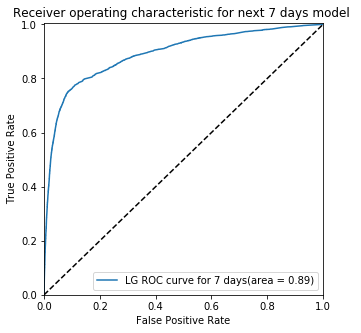

In [89]:
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label='LG ROC curve for 7 days(area = %0.2f)' % roc_lg_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.005])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for next 7 days model ')
plt.legend(loc="lower right")
plt.show()

In [ ]:
############################## 14 days ##############################

rf = RandomForestClassifier()

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': list(range(5, 10)),
    'max_leaf_nodes': list(range(8, 12)),
    'min_samples_split': [2,4,8],
    'max_features': ['sqrt', 'auto', 'log2']
}

rf_gs = GridSearchCV(estimator=rf, param_grid=param_grid)
rf_gs.fit(X_train.iloc[:,1:], y_train['user_purchase_binary_14_days'])

rf_14 = rf_gs.best_estimator_
rf_14.fit(X_train.iloc[:,1:], y_train['user_purchase_binary_14_days'])

In [ ]:
print(rf_14)

In [ ]:
pred_14 = rf_14.predict_proba(X_val.iloc[:,1:])[:,1]

In [91]:
# roc-auc for 14 days

fpr, tpr, thresholds = metrics.roc_curve(y_val['user_purchase_binary_14_days'], pred_14, pos_label=1)
roc_lg_auc = metrics.auc(fpr, tpr)
print(roc_lg_auc)

0.8793977937544752


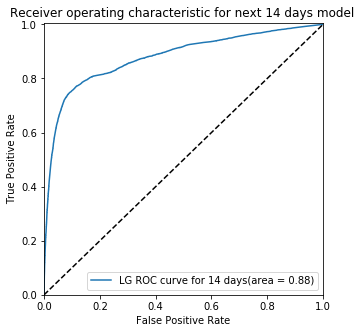

In [92]:
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label='LG ROC curve for 14 days(area = %0.2f)' % roc_lg_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.005])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for next 14 days model ')
plt.legend(loc="lower right")
plt.show()

In [168]:
rf = RandomForestClassifier(n_estimators=100, max_depth =5, max_features = 'log2', max_leaf_nodes= 11)

In [169]:
rf_7 = rf.fit(X_train.iloc[:,1:], y_train['user_purchase_binary_7_days'])
pred_7 = rf.predict_proba(X_val.iloc[:,1:])[:,1]

In [117]:
rf_14 = rf.fit(X_train.iloc[:,1:], y_train['user_purchase_binary_14_days'])
pred_14 = rf.predict_proba(X_val.iloc[:,1:])[:,1]

In [110]:
# roc-auc for 7 days

fpr, tpr, thresholds = metrics.roc_curve(y_val['user_purchase_binary_7_days'], pred_7, pos_label=1)
roc_lg_auc = metrics.auc(fpr, tpr)
print(roc_lg_auc)

0.8920287185122828


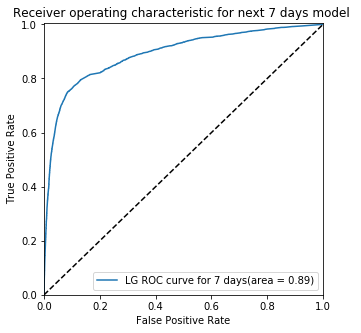

In [111]:
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label='LG ROC curve for 7 days(area = %0.2f)' % roc_lg_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.005])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for next 7 days model ')
plt.legend(loc="lower right")
plt.show()

In [112]:
# roc-auc for 14 days

fpr, tpr, thresholds = metrics.roc_curve(y_val['user_purchase_binary_14_days'], pred_14, pos_label=1)
roc_lg_auc = metrics.auc(fpr, tpr)
print(roc_lg_auc)

0.8801984411404309


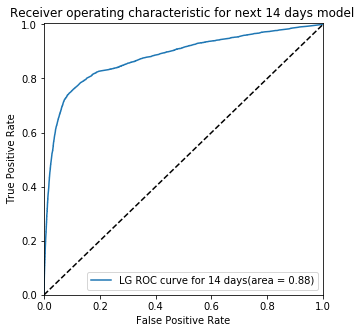

In [113]:
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label='LG ROC curve for 14 days(area = %0.2f)' % roc_lg_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.005])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for next 14 days model ')
plt.legend(loc="lower right")
plt.show()

In [118]:
X_predict['pred_7'] = rf_7.predict_proba(X_predict.iloc[:,1:])[:,1]
X_predict['pred_14'] = rf_14.predict_proba(X_predict.iloc[:,1:-1])[:,1]

In [119]:
pred_7 = X_predict[['user_id_hash','pred_7']]
pred_14 = X_predict[['user_id_hash','pred_14']]

In [120]:
submit = submission.copy()

In [121]:
submit = submit.merge(pred_7, how='left', on='user_id_hash').merge(pred_14, how='left', on='user_id_hash').fillna(0)

In [122]:
# submit = submit.drop(['user_purchase_binary_7_days', 'user_purchase_binary_14_days'],axis=1)
submit = submit.rename(columns={'pred_7':'user_purchase_binary_7_days', 'pred_14':'user_purchase_binary_14_days'})

In [123]:
submit.head()

,user_id_hash,user_purchase_binary_7_days,user_purchase_binary_14_days
0,e469dfaed039ead9110165d9bc457acb11609ca34057dc...,0.000000,0.000000
1,afcc639a324b6c598ef83d360450afa011cb2dd1358bf9...,0.039925,0.083020
2,fd5a7cf211d08e3e00f7be6a9df6e6ea3d2e5c22a5d9c3...,0.038787,0.081117
3,00bfff98b9d0329f014c2eeac7ce47cd18b2bc6e10d608...,0.040012,0.073595
4,0d298f3638c43e915c119d4935e1ce8d168f81b5e3e8c1...,0.000000,0.000000


In [124]:
submit.to_csv('submit_2.csv', index=False)

In [126]:
len(submit)

312568

In [128]:
len(pred_7)

163737

In [135]:
X = compute_features(events_data, sessions_data)
y = training_label[training_label['user_id_hash'].isin(X.user_id_hash)]
len(X)

81975

In [157]:
rf = RandomForestClassifier(n_estimators=100, max_depth =5, max_features = 'log2', max_leaf_nodes= 11)

In [156]:
rf_7 = rf.fit(X.iloc[:,1:], y['user_purchase_binary_7_days'])
# pred_7 = rf.predict_proba(X_val.iloc[:,1:])[:,1]

In [158]:
rf_14 = rf.fit(X.iloc[:,1:], y['user_purchase_binary_14_days'])
# pred_14 = rf.predict_proba(X_val.iloc[:,1:])[:,1]

In [170]:
X_test = compute_features(get_data(events, submission), get_data(sessions, submission))
# y_test = training_label[training_label['user_id_hash'].isin(X.user_id_hash)]
len(X_test)

294124

In [174]:
X_test.head()

,user_id_hash,total_time,total_time_last_week,avg_session_duration_x,avg_session_duration_last_week,avg_event_count,sum_purchase_value,sum_purchase_value_last_week,purchase_count,purchase_count_last_week,purchase_interval,purchase_interval_last_week,session_count,avg_session_duration_y,elapse_since_last_session,since_register,avg_session_interval,avg_session_interval_last_week,pred_7,pred_14
0,00000db35682058bb7916cb90f85709f54c1a0f7a3b6de...,0.441477,0.219348,0.924145,4.518048,1.283193,1.552283,-0.053125,1.815472,-0.053349,-4.427274,0.088203,0.569684,0.185493,-1.892289,-0.564582,-0.883520,-2.329323,0.244510,0.325149
1,000059859ec188af6035870faf885c3038cedda05b3a54...,-0.053697,-0.122268,-0.073329,-0.187696,0.452875,-0.019483,-0.053125,0.110734,-0.053349,-2.098370,0.088203,0.052198,-0.009976,-0.927795,-1.297924,-1.013355,0.256153,0.174659,0.214616
2,000081a7d841b0f953bdba6c185fd5cc335fd6015a30c3...,-0.256374,-0.122268,-0.333810,-0.187696,-0.344722,-0.120609,-0.053125,-0.132800,-0.053349,0.251654,0.088203,-0.226448,-0.232648,-0.892998,-1.301366,-0.979303,0.256153,0.076275,0.056268
3,0000bc4e8bfc829d327fa69bdc426dd8a789c52550ed87...,-0.156948,-0.122268,-0.311196,-0.187696,-0.297002,-0.120609,-0.053125,-0.132800,-0.053349,0.251654,0.088203,0.012391,-0.095007,-1.120403,-1.505182,-1.007967,0.256153,0.076314,0.056031
4,0000c5de50d243cc39f6ac4268d7511705585ca3f2a20f...,-0.240051,-0.122268,-0.132510,-0.187696,0.146107,-0.120609,-0.053125,-0.132800,-0.053349,0.251654,0.088203,-0.226448,-0.239480,-0.025502,0.114124,-0.622029,0.256153,0.052383,0.053172


In [173]:
X_test['pred_7'] = rf_7.predict_proba(X_test.iloc[:,1:])[:,1]
X_test['pred_14'] = rf_14.predict_proba(X_test.iloc[:,1:-1])[:,1]

In [175]:
pred_7 = X_test[['user_id_hash','pred_7']]
pred_14 = X_test[['user_id_hash','pred_14']]

In [176]:
submit = submission.copy()

In [177]:
submit = submit.merge(pred_7, how='left', on='user_id_hash').merge(pred_14, how='left', on='user_id_hash').fillna(0)

In [178]:
# submit = submit.drop(['user_purchase_binary_7_days', 'user_purchase_binary_14_days'],axis=1)
submit = submit.rename(columns={'pred_7':'user_purchase_binary_7_days', 'pred_14':'user_purchase_binary_14_days'})

In [179]:
submit.head()

,user_id_hash,user_purchase_binary_7_days,user_purchase_binary_14_days
0,e469dfaed039ead9110165d9bc457acb11609ca34057dc...,0.053121,0.052760
1,afcc639a324b6c598ef83d360450afa011cb2dd1358bf9...,0.075279,0.056764
2,fd5a7cf211d08e3e00f7be6a9df6e6ea3d2e5c22a5d9c3...,0.053121,0.052760
3,00bfff98b9d0329f014c2eeac7ce47cd18b2bc6e10d608...,0.052252,0.053537
4,0d298f3638c43e915c119d4935e1ce8d168f81b5e3e8c1...,0.052944,0.051728


In [180]:
len(submit)

312568

In [181]:
len(pred_14)

294124

In [182]:
submit.to_csv('submit_3.csv', index=False)

In [148]:
rf_7 = RandomForestClassifier(n_estimators=100, max_depth =5, max_features = 'sqrt', max_leaf_nodes= 8).\
                    fit(X_train.iloc[:,1:], y_train['user_purchase_binary_7_days'])
rf_14 = RandomForestClassifier(n_estimators=100, max_depth =5, max_features = 'sqrt', max_leaf_nodes= 8).\
                    fit(X_train.iloc[:,1:], y_train['user_purchase_binary_14_days'])

### predict

In [149]:
submission = pd.read_csv('../Data/sample_submission_2.csv')

In [150]:
events_pred = get_training_data(events, submission)
sessions_pred = get_training_data(sessions, submission)

In [151]:
X_events = compute_event_features(events_pred)
X_sessions = compute_session_features(sessions_pred)

In [152]:
X_test = X_events.merge(X_sessions, how='inner', on='user_id_hash').reset_index(drop=True)

In [153]:
X_test.head()

,user_id_hash,total_time,total_time_last_week,total_time_last_two_week,avg_session_duration_x,avg_session_duration_last_week,avg_session_duration_last_two_week,avg_event_count,sum_purchase_value,sum_purchase_value_last_week,...,purchase_interval_last_two_week,session_count,avg_session_duration_y,country,os_name,elapse_since_last_session,since_register,avg_session_interval,avg_session_interval_last_week,avg_session_interval_last_two_week
0,00000db35682058bb7916cb90f85709f54c1a0f7a3b6de...,7.426202,0.497496,0.497496,0.495080,0.497496,0.497496,39.533333,23.044,0.0,...,336.0,23,2.137217,AU,iOS,36.466749,832.988641,36.205541,84.0,168.0
1,000059859ec188af6035870faf885c3038cedda05b3a54...,2.489036,0.000000,0.000000,0.226276,0.000000,0.000000,26.000000,1.393,0.0,...,336.0,10,1.256751,US,Android OS,488.904023,532.828048,4.880447,168.0,336.0
2,000081a7d841b0f953bdba6c185fd5cc335fd6015a30c3...,0.468241,0.000000,0.000000,0.156080,0.000000,0.000000,13.000000,0.000,0.0,...,336.0,3,0.253750,US,Android OS,505.226882,531.418912,13.096015,168.0,336.0
3,0000bc4e8bfc829d327fa69bdc426dd8a789c52550ed87...,1.459572,0.000000,0.000000,0.162175,0.000000,0.000000,13.777778,0.000,0.0,...,336.0,9,0.873740,RO,Android OS,398.552951,447.996161,6.180239,168.0,336.0
4,0000c5de50d243cc39f6ac4268d7511705585ca3f2a20f...,0.630983,0.000000,0.000000,0.210328,0.000000,0.000000,21.000000,0.000,0.0,...,336.0,3,0.222979,US,Android OS,912.163312,1110.786054,99.295397,168.0,336.0


In [154]:
X_test.columns

Index(['user_id_hash', 'total_time', 'total_time_last_week',
       'total_time_last_two_week', 'avg_session_duration_x',
       'avg_session_duration_last_week', 'avg_session_duration_last_two_week',
       'avg_event_count', 'sum_purchase_value', 'sum_purchase_value_last_week',
       'sum_purchase_value_last_two_week', 'purchase_count',
       'purchase_count_last_week', 'purchase_count_last_two_week',
       'purchase_interval', 'purchase_interval_last_week',
       'purchase_interval_last_two_week', 'session_count',
       'avg_session_duration_y', 'country', 'os_name',
       'elapse_since_last_session', 'since_register', 'avg_session_interval',
       'avg_session_interval_last_week', 'avg_session_interval_last_two_week'],
      dtype='object')

In [155]:
X_test = X_test.drop(['country','os_name'],axis=1)

In [158]:
for c in list(X_test.columns)[1:]:
    X_test[c] = standardize(X_test[c])

In [165]:
X_test.iloc[:,1:].head()

,total_time,total_time_last_week,total_time_last_two_week,avg_session_duration_x,avg_session_duration_last_week,avg_session_duration_last_two_week,avg_event_count,sum_purchase_value,sum_purchase_value_last_week,sum_purchase_value_last_two_week,...,purchase_interval,purchase_interval_last_week,purchase_interval_last_two_week,session_count,avg_session_duration_y,elapse_since_last_session,since_register,avg_session_interval,avg_session_interval_last_week,avg_session_interval_last_two_week
0,0.440217,0.218671,0.029979,0.921489,4.510104,3.647894,1.280341,1.549307,-0.053231,-0.064054,...,-4.373108,0.08838,0.115642,0.538464,0.164501,-1.871246,-0.567101,-0.853357,-2.260789,-1.637985
1,-0.054449,-0.122488,-0.143354,-0.075625,-0.188013,-0.234375,0.450070,-0.019846,-0.053231,-0.064054,...,-2.067668,0.08838,0.115642,0.034025,-0.026005,-0.911683,-1.299708,-0.944641,0.262829,0.339196
2,-0.256917,-0.122488,-0.143354,-0.336012,-0.188013,-0.234375,-0.347481,-0.120804,-0.053231,-0.064054,...,0.252367,0.08838,0.115642,-0.237596,-0.243023,-0.877065,-1.303147,-0.920700,0.262829,0.339196
3,-0.157593,-0.122488,-0.143354,-0.313405,-0.188013,-0.234375,-0.299764,-0.120804,-0.053231,-0.064054,...,0.252367,0.08838,0.115642,-0.004778,-0.108876,-1.103307,-1.506758,-0.940853,0.262829,0.339196
4,-0.240611,-0.122488,-0.143354,-0.134784,-0.188013,-0.234375,0.143320,-0.120804,-0.053231,-0.064054,...,0.252367,0.08838,0.115642,-0.237596,-0.249681,-0.014003,0.110923,-0.669507,0.262829,0.339196


In [161]:
len(X_test)

294124

In [169]:
rf_7.predict_proba(X_test.iloc[:,1:])[:,1]

array([0.18045177, 0.13939927, 0.08468149, ..., 0.06325   , 0.08468149,
       0.06995641])

In [170]:
X_test['pred_7'] = rf_7.predict_proba(X_test.iloc[:,1:])[:,1]
X_test['pred_14'] = rf_14.predict_proba(X_test.iloc[:,1:-1])[:,1]

In [171]:
pred_7 = X_test[['user_id_hash','pred_7']]
pred_14 = X_test[['user_id_hash','pred_14']]

In [172]:
submit = submission.copy()
submit = submit.merge(pred_7, how='left', on='user_id_hash').merge(pred_14, how='left', on='user_id_hash').fillna(0)

In [173]:
submit = submit.drop(['user_purchase_binary_7_days', 'user_purchase_binary_14_days'],axis=1)

In [179]:
submit = submit.rename(columns={'pred_7':'user_purchase_binary_7_days', 'pred_14':'user_purchase_binary_14_days'})

In [180]:
submit.head()

,user_id_hash,user_purchase_binary_7_days,user_purchase_binary_14_days
0,e469dfaed039ead9110165d9bc457acb11609ca34057dc...,0.062124,0.100939
1,afcc639a324b6c598ef83d360450afa011cb2dd1358bf9...,0.084681,0.110099
2,fd5a7cf211d08e3e00f7be6a9df6e6ea3d2e5c22a5d9c3...,0.062124,0.099118
3,00bfff98b9d0329f014c2eeac7ce47cd18b2bc6e10d608...,0.062335,0.102973
4,0d298f3638c43e915c119d4935e1ce8d168f81b5e3e8c1...,0.062124,0.099118


In [181]:
submit.to_csv('prediction.csv', index=False)

In [182]:
len(submit)

312568

## using validation set

### train using subset 1

In [85]:
train_events_X_1 = compute_event_features(train_events_data_1)
print(len(train_events_X_1))
train_events_X_1.head()

65672


,user_id_hash,total_time,total_time_last_week,total_time_last_two_week,avg_session_duration,avg_session_duration_last_week,avg_session_duration_last_two_week,avg_event_count,sum_purchase_value,sum_purchase_value_last_week,sum_purchase_value_last_two_week,purchase_count,purchase_count_last_week,purchase_count_last_two_week,purchase_interval,purchase_interval_last_week,purchase_interval_last_two_week
0,00000db35682058bb7916cb90f85709f54c1a0f7a3b6de...,6.928706,0.000000,0.000000,0.494908,0.000000,0.000000,36.071429,23.044,0.0,0.0,8.0,0.0,0.0,4.529346,168.0,336.0
1,0000a464ad921c3288e73a3a788b5f113cabf84251a74b...,0.278788,0.000000,0.278788,0.139394,0.000000,0.139394,12.500000,0.000,0.0,0.0,0.0,0.0,0.0,1440.000000,168.0,336.0
2,0000bc4e8bfc829d327fa69bdc426dd8a789c52550ed87...,1.459572,1.459572,1.459572,0.182446,0.182446,0.182446,15.375000,0.000,0.0,0.0,0.0,0.0,0.0,1440.000000,168.0,336.0
3,0002e987a7c0f2c23b8ef2230f3934c77ed94a15778d2c...,1.750760,1.750760,1.750760,0.350152,0.350152,0.350152,27.200000,0.000,0.0,0.0,0.0,0.0,0.0,1440.000000,168.0,336.0
4,000640d9f785d21ded61bdff159144b25dea23300ae1b8...,43.717894,5.217313,19.218381,0.361305,0.289851,0.343185,23.322314,0.000,0.0,0.0,0.0,0.0,0.0,1440.000000,168.0,336.0


In [86]:
train_sessions_X_1 = compute_session_features(train_sessions_data_1)
print(len(train_sessions_X_1))
train_sessions_X_1.head()

67079


,user_id_hash,session_count,avg_session_duration,country,os_name,elapse_since_last_session,since_register,avg_session_interval,avg_session_interval_last_week,avg_session_interval_last_two_week
0,00000db35682058bb7916cb90f85709f54c1a0f7a3b6de...,22,1.980453,AU,iOS,326.751133,496.990247,8.106624,168.000000,168.000000
1,0000a464ad921c3288e73a3a788b5f113cabf84251a74b...,2,0.149162,US,iOS,190.540179,209.772951,19.232772,168.000000,19.232772
2,0000bc4e8bfc829d327fa69bdc426dd8a789c52550ed87...,9,0.873740,RO,Android OS,62.554556,111.997767,6.180239,6.180239,6.180239
3,0002e987a7c0f2c23b8ef2230f3934c77ed94a15778d2c...,6,0.987521,US,Android OS,0.055704,44.345226,8.857904,8.857904,8.857904
4,000640d9f785d21ded61bdff159144b25dea23300ae1b8...,154,21.923546,SV,Android OS,7.673025,632.209240,4.081895,8.179413,5.329350


In [87]:
# not use country and os_name
train_sessions_X_1 = train_sessions_X_1.drop(['country', 'os_name'], axis=1)
train_sessions_X_1.head()

,user_id_hash,session_count,avg_session_duration,elapse_since_last_session,since_register,avg_session_interval,avg_session_interval_last_week,avg_session_interval_last_two_week
0,00000db35682058bb7916cb90f85709f54c1a0f7a3b6de...,22,1.980453,326.751133,496.990247,8.106624,168.000000,168.000000
1,0000a464ad921c3288e73a3a788b5f113cabf84251a74b...,2,0.149162,190.540179,209.772951,19.232772,168.000000,19.232772
2,0000bc4e8bfc829d327fa69bdc426dd8a789c52550ed87...,9,0.873740,62.554556,111.997767,6.180239,6.180239,6.180239
3,0002e987a7c0f2c23b8ef2230f3934c77ed94a15778d2c...,6,0.987521,0.055704,44.345226,8.857904,8.857904,8.857904
4,000640d9f785d21ded61bdff159144b25dea23300ae1b8...,154,21.923546,7.673025,632.209240,4.081895,8.179413,5.329350


In [88]:
for c in list(train_events_X_1.columns)[1:]:
    train_events_X_1[c] = standardize(train_events_X_1[c])

In [89]:
# standardize
for c in ['session_count', 'avg_session_duration','elapse_since_last_session', 'since_register',
       'avg_session_interval', 'avg_session_interval_last_week',
       'avg_session_interval_last_two_week']:
    train_sessions_X_1[c] = standardize(train_sessions_X_1[c])

In [93]:
X_train_1 = train_events_X_1.merge(train_sessions_X_1, how='inner', on='user_id_hash').reset_index(drop=True)
y_train_1 = train_label_1[train_label_1['user_id_hash'].isin(X_train_1.user_id_hash)]
len(X_train_1)

65595

In [94]:
X_train_1.head()

,user_id_hash,total_time,total_time_last_week,total_time_last_two_week,avg_session_duration_x,avg_session_duration_last_week,avg_session_duration_last_two_week,avg_event_count,sum_purchase_value,sum_purchase_value_last_week,...,purchase_interval,purchase_interval_last_week,purchase_interval_last_two_week,session_count,avg_session_duration_y,elapse_since_last_session,since_register,avg_session_interval,avg_session_interval_last_week,avg_session_interval_last_two_week
0,00000db35682058bb7916cb90f85709f54c1a0f7a3b6de...,-0.063264,-0.486369,-0.506823,0.396234,-0.789436,-0.974992,0.564164,0.869346,-0.150153,...,-2.850669,0.258645,0.30493,-0.008376,-0.221329,0.504879,0.085448,-0.544087,1.318052,0.468335
1,0000a464ad921c3288e73a3a788b5f113cabf84251a74b...,-0.471223,-0.486369,-0.466019,-0.865129,-0.789436,-0.518643,-0.800048,-0.184819,-0.150153,...,0.386844,0.258645,0.30493,-0.483069,-0.465831,0.003869,-0.624318,-0.502902,1.318052,-0.714164
2,0000bc4e8bfc829d327fa69bdc426dd8a789c52550ed87...,-0.398784,-0.122419,-0.293196,-0.712380,-0.206835,-0.377698,-0.633655,-0.184819,-0.150153,...,0.386844,0.258645,0.30493,-0.316926,-0.369090,-0.466886,-0.865939,-0.551218,-1.033395,-0.817914
3,0002e987a7c0f2c23b8ef2230f3934c77ed94a15778d2c...,-0.380920,-0.049810,-0.250577,-0.117360,0.328695,0.171337,0.050724,-0.184819,-0.150153,...,0.386844,0.258645,0.30493,-0.388130,-0.353899,-0.696769,-1.033120,-0.541306,-0.994485,-0.796630
4,000640d9f785d21ded61bdff159144b25dea23300ae1b8...,2.193675,0.814588,2.306028,-0.077789,0.136136,0.148530,-0.173699,-0.184819,-0.150153,...,0.386844,0.258645,0.30493,3.124599,2.441336,-0.668751,0.419599,-0.558985,-1.004345,-0.824678


In [95]:
rf_7 = RandomForestClassifier(n_estimators=100, max_depth =5, max_features = 'sqrt', max_leaf_nodes= 8).\
                    fit(X_train_1.iloc[:,1:], y_train_1['user_purchase_binary_7_days'])
rf_14 = RandomForestClassifier(n_estimators=100, max_depth =5, max_features = 'sqrt', max_leaf_nodes= 8).\
                    fit(X_train_1.iloc[:,1:], y_train_1['user_purchase_binary_14_days'])

### validation

In [109]:
val_events_X_1 = compute_event_features(val_events_data_1)
print(len(val_events_X_1))
val_events_X_1.head()

16398


,user_id_hash,total_time,total_time_last_week,total_time_last_two_week,avg_session_duration,avg_session_duration_last_week,avg_session_duration_last_two_week,avg_event_count,sum_purchase_value,sum_purchase_value_last_week,sum_purchase_value_last_two_week,purchase_count,purchase_count_last_week,purchase_count_last_two_week,purchase_interval,purchase_interval_last_week,purchase_interval_last_two_week
0,000081a7d841b0f953bdba6c185fd5cc335fd6015a30c3...,0.468241,0.000000,0.468241,0.234120,0.000000,0.234120,19.000000,0.0,0.0,0.0,0.0,0.0,0.0,1440.0,168.0,336.0
1,00020102f66f89759868c843ae9fe634870f132f9e3d79...,0.093692,0.093692,0.093692,0.093692,0.093692,0.093692,14.000000,0.0,0.0,0.0,0.0,0.0,0.0,1440.0,168.0,336.0
2,0007e356e960e1a802454c83e1a6cea122cbd32d6382df...,0.703842,0.000000,0.703842,0.703842,0.000000,0.703842,41.000000,0.0,0.0,0.0,0.0,0.0,0.0,1440.0,168.0,336.0
3,000c48f36832eb902f680d4ff9b6b93684352a9100a5fe...,0.108426,0.000000,0.000000,0.108426,0.000000,0.000000,11.000000,0.0,0.0,0.0,0.0,0.0,0.0,1440.0,168.0,336.0
4,000e54395ce0694f3a6b95bbdd48759e3d18c7051650b4...,14.285491,0.287129,1.666413,0.324670,0.287129,0.277736,24.409091,0.0,0.0,0.0,0.0,0.0,0.0,1440.0,168.0,336.0


In [110]:
val_sessions_X_1 = compute_session_features(val_sessions_data_1)
print(len(val_sessions_X_1))
val_sessions_X_1.head()

16763


,user_id_hash,session_count,avg_session_duration,country,os_name,elapse_since_last_session,since_register,avg_session_interval,avg_session_interval_last_week,avg_session_interval_last_two_week
0,000081a7d841b0f953bdba6c185fd5cc335fd6015a30c3...,3,0.253750,US,Android OS,169.228539,195.420569,13.096015,168.000000,13.096015
1,00020102f66f89759868c843ae9fe634870f132f9e3d79...,1,0.000000,GB,iOS,3.762060,3.762060,720.000000,84.000000,168.000000
2,0007e356e960e1a802454c83e1a6cea122cbd32d6382df...,2,0.373987,US,iOS,226.384016,233.684354,7.300338,168.000000,7.300338
3,000c48f36832eb902f680d4ff9b6b93684352a9100a5fe...,2,0.067656,AU,iOS,1024.113060,1045.479911,21.366851,168.000000,336.000000
4,000e54395ce0694f3a6b95bbdd48759e3d18c7051650b4...,56,7.690253,US,iOS,31.365213,643.438218,11.128600,52.990373,27.858972


In [111]:
# not use country and os_name
val_sessions_X_1 = val_sessions_X_1.drop(['country', 'os_name'], axis=1)
val_sessions_X_1.head()

,user_id_hash,session_count,avg_session_duration,elapse_since_last_session,since_register,avg_session_interval,avg_session_interval_last_week,avg_session_interval_last_two_week
0,000081a7d841b0f953bdba6c185fd5cc335fd6015a30c3...,3,0.253750,169.228539,195.420569,13.096015,168.000000,13.096015
1,00020102f66f89759868c843ae9fe634870f132f9e3d79...,1,0.000000,3.762060,3.762060,720.000000,84.000000,168.000000
2,0007e356e960e1a802454c83e1a6cea122cbd32d6382df...,2,0.373987,226.384016,233.684354,7.300338,168.000000,7.300338
3,000c48f36832eb902f680d4ff9b6b93684352a9100a5fe...,2,0.067656,1024.113060,1045.479911,21.366851,168.000000,336.000000
4,000e54395ce0694f3a6b95bbdd48759e3d18c7051650b4...,56,7.690253,31.365213,643.438218,11.128600,52.990373,27.858972


In [112]:
for c in list(val_events_X_1.columns)[1:]:
    val_events_X_1[c] = standardize(val_events_X_1[c])

In [113]:
# standardize
for c in ['session_count', 'avg_session_duration','elapse_since_last_session', 'since_register',
       'avg_session_interval', 'avg_session_interval_last_week',
       'avg_session_interval_last_two_week']:
    val_sessions_X_1[c] = standardize(val_sessions_X_1[c])

In [114]:
X_val_1 = val_events_X_1.merge(val_sessions_X_1, how='inner', on='user_id_hash').reset_index(drop=True)
y_val_1 = val_label_1[val_label_1['user_id_hash'].isin(X_val_1.user_id_hash)]
len(X_val_1)

16380

In [115]:
X_val_1.head()

,user_id_hash,total_time,total_time_last_week,total_time_last_two_week,avg_session_duration_x,avg_session_duration_last_week,avg_session_duration_last_two_week,avg_event_count,sum_purchase_value,sum_purchase_value_last_week,...,purchase_interval,purchase_interval_last_week,purchase_interval_last_two_week,session_count,avg_session_duration_y,elapse_since_last_session,since_register,avg_session_interval,avg_session_interval_last_week,avg_session_interval_last_two_week
0,000081a7d841b0f953bdba6c185fd5cc335fd6015a30c3...,-0.463280,-0.493589,-0.441637,-0.509253,-0.782078,-0.214546,-0.374540,-0.200991,-0.158207,...,0.391406,0.261816,0.306336,-0.447887,-0.461018,-0.060721,-0.653042,-0.533460,1.327898,-0.764872
1,00020102f66f89759868c843ae9fe634870f132f9e3d79...,-0.485979,-0.469793,-0.496575,-0.975095,-0.489776,-0.651810,-0.616560,-0.200991,-0.158207,...,0.391406,0.261816,0.306336,-0.492846,-0.495087,-0.681383,-1.125878,2.048783,0.100773,0.472521
2,0007e356e960e1a802454c83e1a6cea122cbd32d6382df...,-0.449001,-0.493589,-0.407080,1.048948,-0.782078,1.248065,0.690350,-0.200991,-0.158207,...,0.391406,0.261816,0.306336,-0.470367,-0.444875,0.153668,-0.558642,-0.554631,1.327898,-0.811168
3,000c48f36832eb902f680d4ff9b6b93684352a9100a5fe...,-0.485086,-0.493589,-0.510317,-0.926218,-0.782078,-0.943546,-0.761772,-0.200991,-0.158207,...,0.391406,0.261816,0.306336,-0.470367,-0.486003,3.145936,1.444118,-0.503247,1.327898,1.814527
4,000e54395ce0694f3a6b95bbdd48759e3d18c7051650b4...,0.374106,-0.420664,-0.265893,-0.208874,0.113713,-0.078738,-0.112718,-0.200991,-0.158207,...,0.391406,0.261816,0.306336,0.743541,0.537424,-0.577844,0.452251,-0.540647,-0.352236,-0.646943


In [116]:
# predict
X_val_1['pred_7'] = rf_7.predict_proba(X_val_1.iloc[:,1:])[:,1]
X_val_1['pred_14'] = rf_14.predict_proba(X_val_1.iloc[:,1:-1])[:,1]

pred_7 = X_val_1[['user_id_hash','pred_7']]
pred_14 = X_val_1[['user_id_hash','pred_14']]

y_val_1 = val_label_1.merge(pred_7, how='left', on='user_id_hash').merge(pred_14, how='left', on='user_id_hash').fillna(0)

In [117]:
y_val_1.head()

,user_id_hash,user_purchase_binary_14_days,user_purchase_binary_7_days,pred_7,pred_14
0,1e5f2870732c749aa68f2763c078f2962af27c74340acf...,0,0.0,0.053359,0.072025
1,436c43808fac6f7b40e595abb68b9754bed32a2c7aeb8f...,1,1.0,0.055830,0.072288
2,c36c48be9645c609270b03d92257c0b062b790874597f8...,0,0.0,0.075170,0.087439
3,e16ae9801f4477d9f252e806eac67494dd6fb8e757435c...,0,0.0,0.056235,0.073339
4,ffa885f430a31606c8023ef48e718ac24b280622bdec4f...,0,0.0,0.056147,0.073449


### performance

In [122]:
# roc-auc for 7 days

fpr, tpr, thresholds = metrics.roc_curve(y_val_1['user_purchase_binary_7_days'], y_val_1['pred_7'], pos_label=1)
roc_lg_auc = metrics.auc(fpr, tpr)
print(roc_lg_auc)

0.6455012961862278


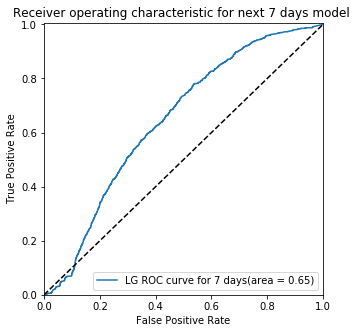

In [119]:
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label='LG ROC curve for 7 days(area = %0.2f)' % roc_lg_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.005])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for next 7 days model ')
plt.legend(loc="lower right")
plt.show()

In [120]:
# roc-auc for 14 days

fpr, tpr, thresholds = metrics.roc_curve(y_val_1['user_purchase_binary_14_days'], y_val_1['pred_14'], pos_label=1)
roc_lg_auc = metrics.auc(fpr, tpr)
print(roc_lg_auc)

0.4405992590810044


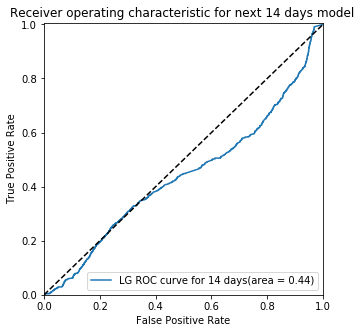

In [121]:
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label='LG ROC curve for 14 days(area = %0.2f)' % roc_lg_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.005])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for next 14 days model ')
plt.legend(loc="lower right")
plt.show()